# Installs & Imports

In [1]:
# Install tkan without dependencies
!pip install -q tkan --no-deps

In [2]:
# Install keras_efficient_kan without dependencies
!pip install -q keras_efficient_kan --no-deps

In [3]:
# Install yfinance and optuna
!pip install -q yfinance optuna optuna_integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.9/96.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00


In [4]:
import numpy
import cupy
import keras
import keras_efficient_kan
import tkan
import yfinance
import optuna
import tensorflow
import torch
import jax
import jaxlib

print(f"NumPy version: {numpy.__version__}")
print(f"Cupy version: {cupy.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Yfinance version: {yfinance.__version__}")
print(f"Optuna version: {optuna.__version__}")
print(f"TensorFlow version: {tensorflow.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"JAX version: {jax.__version__}")
print(f"JAXlib version: {jaxlib.__version__}")

NumPy version: 1.26.4
Cupy version: 12.2.0
Keras version: 3.4.1
Yfinance version: 0.2.44
Optuna version: 4.0.0
TensorFlow version: 2.17.0
PyTorch version: 2.4.1+cu121
JAX version: 0.4.33
JAXlib version: 0.4.33


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tkan import TKAN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import yfinance as yf
from datetime import datetime
import warnings
import optuna
from sklearn.model_selection import TimeSeriesSplit
from optuna_integration import KerasPruningCallback

warnings.filterwarnings('ignore')

In [6]:
def set_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seeds(42)

# Load the Data

In [7]:
def load_data(ticker='^GSPC', start_date='2010-01-01', end_date=datetime.today().strftime('%Y-%m-%d')):
    """
    Loads historical stock data from Yahoo Finance.

    Args:
        ticker (str): Stock ticker symbol. '^GSPC' represents the S&P 500 index.
        start_date (str): Start date for historical data in 'YYYY-MM-DD' format.
        end_date (str): End date for historical data in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: Historical stock data.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    return data

In [8]:
# Load S&P 500 data
data = load_data()

# Display the first few rows
print("\n\nInitial Data:")
display(data.head())
print("\n")
display(data.tail())

[*********************100%***********************]  1 of 1 completed



Initial Data:


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
1,2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2,2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
3,2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
4,2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


,Date,Open,High,Low,Close,Adj Close,Volume
3720,2024-10-15,5866.740234,5870.359863,5804.479980,5815.259766,5815.259766,3882120000
3721,2024-10-16,5816.580078,5846.520020,5808.339844,5842.470215,5842.470215,3467230000
3722,2024-10-17,5875.620117,5878.459961,5840.250000,5841.470215,5841.470215,3480010000
3723,2024-10-18,5859.430176,5872.169922,5846.109863,5864.669922,5864.669922,3374490000
3724,2024-10-21,5857.819824,5866.919922,5824.790039,5853.979980,5853.979980,3407010000


# Prepare the Data

In [9]:
def preprocess_data(data, moving_average_window=30):
    """
    Preprocesses the data by selecting relevant columns, handling missing values,
    sorting by date, and adding a moving average feature.

    Args:
        data (pd.DataFrame): Raw stock data.
        moving_average_window (int): Window size for moving average.

    Returns:
        pd.DataFrame: Preprocessed data with moving average.
    """
    # Select relevant columns
    data = data[['Date', 'Close']].copy()

    # Sort by date
    data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

    # Add moving average
    data['MA'] = data['Close'].rolling(window=moving_average_window).mean()

    # Drop rows with NaN values due to moving average
    data = data.dropna().reset_index(drop=True)

    return data

In [10]:
# Preprocess the data
data = preprocess_data(data, moving_average_window=30)

# Display the first few rows after preprocessing
print("Preprocessed Data:")
display(data.head())

Preprocessed Data:


,Date,Close,MA
0,2010-02-16,1094.869995,1107.045996
1,2010-02-17,1099.510010,1105.929997
2,2010-02-18,1106.750000,1104.937663
3,2010-02-19,1109.170044,1104.005330
4,2010-02-22,1108.010010,1102.882666


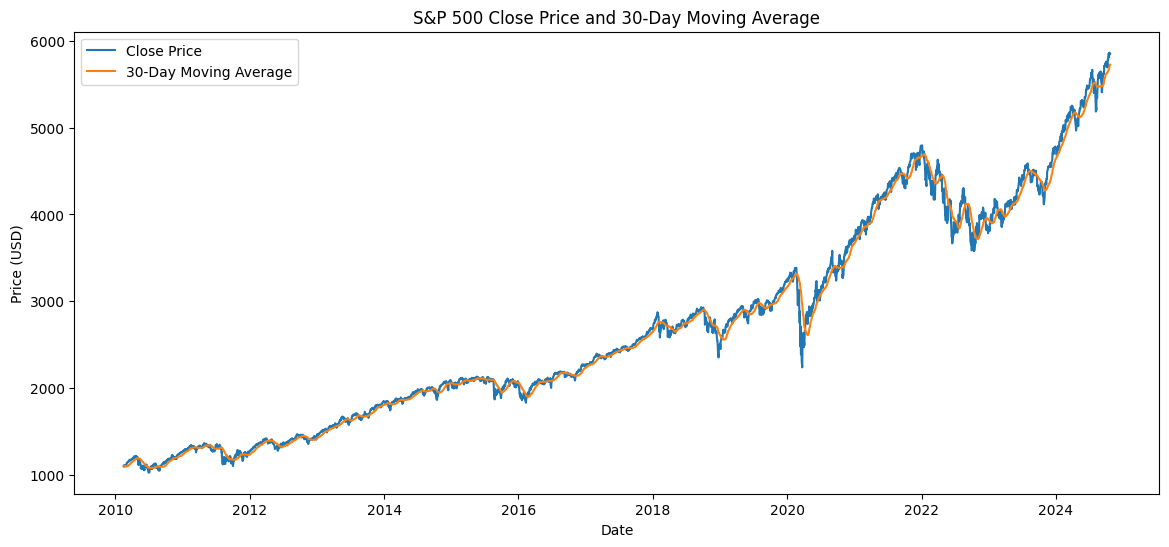

In [11]:
def plot_initial_series(data):
    """
    Plots the original 'Close' price and its moving average.

    Args:
        data (pd.DataFrame): Preprocessed data.
    """
    plt.figure(figsize=(14,6))
    plt.plot(data['Date'], data['Close'], label='Close Price')
    plt.plot(data['Date'], data['MA'], label='30-Day Moving Average')
    plt.title('S&P 500 Close Price and 30-Day Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

plot_initial_series(data)

In [12]:
def scale_data(data, feature_columns):
    """
    Scales the specified feature columns using MinMaxScaler.

    Args:
        data (pd.DataFrame): Data to scale.
        feature_columns (list): List of column names to scale.

    Returns:
        np.ndarray, MinMaxScaler: Scaled data and the scaler object.
    """
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data[feature_columns])
    return scaled_data, scaler

In [13]:
# Features to scale
feature_columns = ['Close', 'MA']

# Scale the data
scaled_data, scaler = scale_data(data, feature_columns)

# Convert scaled data back to DataFrame for visualization
scaled_df = pd.DataFrame(scaled_data, columns=['Close_Scaled', 'MA_Scaled'])
scaled_df['Date'] = data['Date']

# Display the first few rows of scaled data
print("Scaled Data:")
display(scaled_df.head())

Scaled Data:


,Close_Scaled,MA_Scaled,Date
0,0.014929,0.006683,2010-02-16
1,0.015888,0.006443,2010-02-17
2,0.017383,0.006230,2010-02-18
3,0.017883,0.006029,2010-02-19
4,0.017643,0.005788,2010-02-22


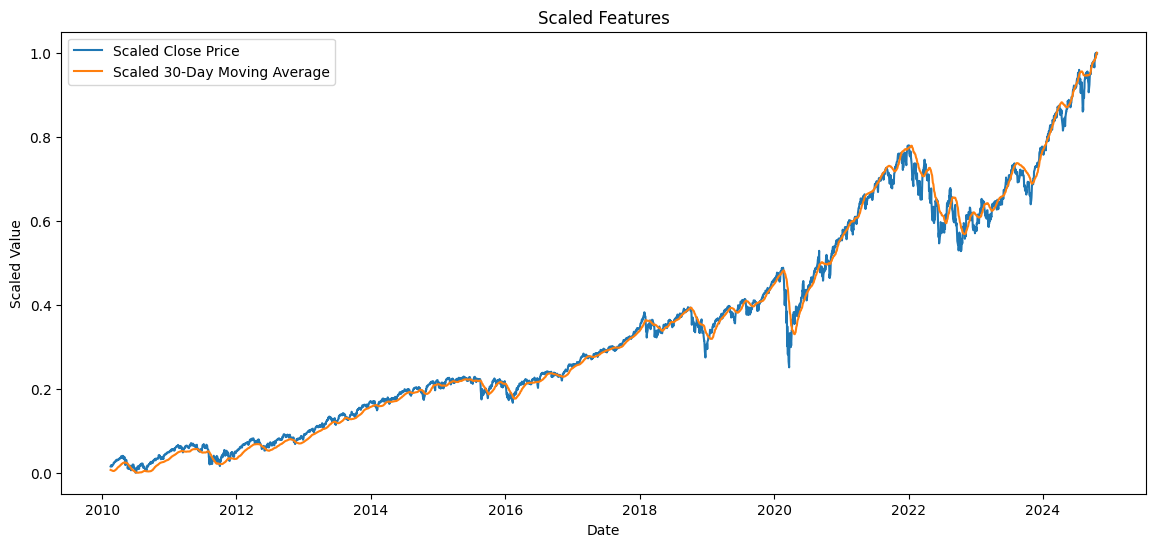

In [14]:
def plot_scaled_features(scaled_df):
    """
    Plots the scaled 'Close' price and scaled moving average.

    Args:
        scaled_df (pd.DataFrame): DataFrame containing scaled features.
    """
    plt.figure(figsize=(14,6))
    plt.plot(scaled_df['Date'], scaled_df['Close_Scaled'], label='Scaled Close Price')
    plt.plot(scaled_df['Date'], scaled_df['MA_Scaled'], label='Scaled 30-Day Moving Average')
    plt.title('Scaled Features')
    plt.xlabel('Date')
    plt.ylabel('Scaled Value')
    plt.legend()
    plt.show()

plot_scaled_features(scaled_df)

In [15]:
def create_windowed_dataset(scaled_data, window_size, future_steps=1):
    """
    Creates windowed datasets for time series forecasting.

    Args:
        scaled_data (np.ndarray): Scaled feature data.
        window_size (int): Number of past time steps to use.
        future_steps (int): Number of future time steps to predict.

    Returns:
        np.ndarray, np.ndarray: Feature and target datasets.
    """
    X, y = [], []
    for i in range(len(scaled_data) - window_size - future_steps + 1):
        X.append(scaled_data[i:i + window_size])
        y.append(scaled_data[i + window_size + future_steps -1, 0])  # 'Close_Scaled' is the first feature
    return np.array(X), np.array(y)

In [16]:
# Define window size and forecast steps
window_size = 30  # Using a 30-day window to align with the moving average
future_steps = 1  # One-step ahead forecasting

# Create windowed dataset
X, y = create_windowed_dataset(scaled_data, window_size, future_steps)

print(f"Shape of X: {X.shape}")  # Expected: (samples, 30, 2)
print(f"Shape of y: {y.shape}")  # Expected: (samples,)

Shape of X: (3666, 30, 2)
Shape of y: (3666,)


In [17]:
def split_data(X, y, train_ratio=0.8):
    """
    Splits the data into training and testing sets.

    Args:
        X (np.ndarray): Feature dataset.
        y (np.ndarray): Target dataset.
        train_ratio (float): Proportion of data to use for training.

    Returns:
        Tuple of np.ndarrays: X_train, X_test, y_train, y_test
    """
    split_index = int(len(X) * train_ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]
    return X_train, X_test, y_train, y_test

In [18]:
# Split the dataset
X_train, X_test, y_train, y_test = split_data(X, y, train_ratio=0.8)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

Training samples: 2932
Testing samples: 734


In [19]:
def plot_original_train_test_split(original_df, split_index):
    """
    Visualizes the training and testing splits on the original data with distinct colors
    and a vertical dotted line indicating the split point.

    Args:
        original_df (pd.DataFrame): DataFrame containing original 'Close' prices and dates.
        split_index (int): Index at which to split the data into training and testing sets.
    """
    # Split the original data
    train_original = original_df.iloc[:split_index].copy()
    test_original = original_df.iloc[split_index:].copy()

    # Determine the split date
    split_date = original_df['Date'].iloc[split_index]

    # Plot original data split
    plt.figure(figsize=(14,6))
    plt.plot(train_original['Date'], train_original['Close'], label='Training Set', color='blue')
    plt.plot(test_original['Date'], test_original['Close'], label='Testing Set', color='orange')
    plt.axvline(x=split_date, color='red', linestyle='--', label='Train/Test Split')
    plt.title('Original Data: Training and Testing Split')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

In [20]:
# Define the split_index
total_original_samples = len(data)
split_index = int(total_original_samples * 0.8)

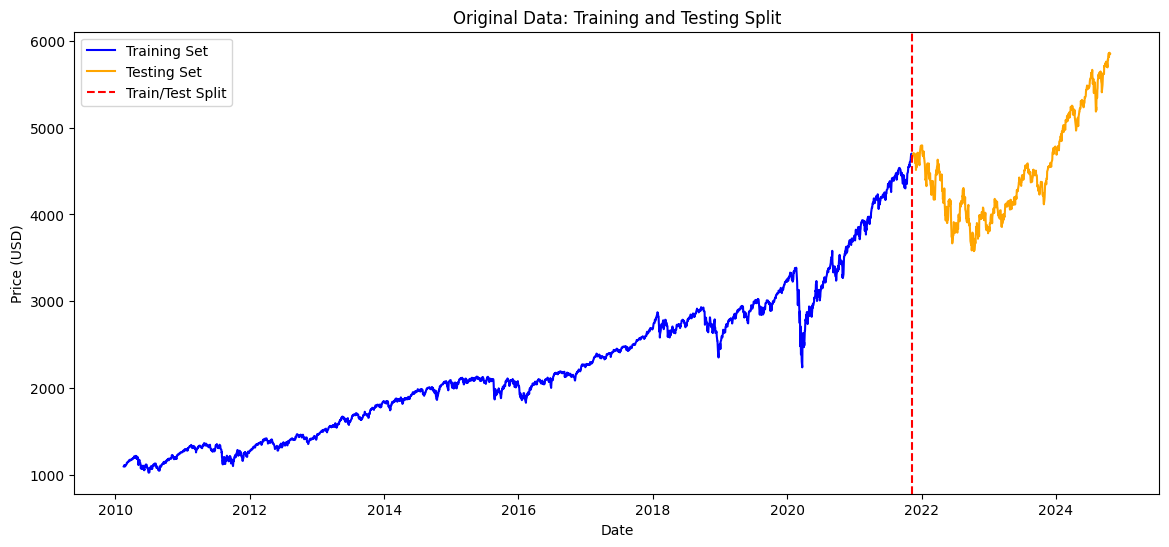

In [21]:
# Visualize the train/test split
plot_original_train_test_split(data, split_index)

In [22]:
def plot_scaled_train_test_split(scaled_df, split_index):
    """
    Visualizes the training and testing splits on the scaled data with distinct colors
    and a vertical dotted line indicating the split point.

    Args:
        scaled_df (pd.DataFrame): DataFrame containing scaled 'Close_Scaled' prices and dates.
        split_index (int): Index at which to split the data into training and testing sets.
    """
    # Split the scaled data
    train_scaled = scaled_df.iloc[:split_index].copy()
    test_scaled = scaled_df.iloc[split_index:].copy()

    # Determine the split date
    split_date = scaled_df['Date'].iloc[split_index]

    # Plot scaled data split
    plt.figure(figsize=(14,6))
    plt.plot(train_scaled['Date'], train_scaled['Close_Scaled'], label='Training Set', color='green')
    plt.plot(test_scaled['Date'], test_scaled['Close_Scaled'], label='Testing Set', color='red')
    plt.axvline(x=split_date, color='blue', linestyle='--', label='Train/Test Split')
    plt.title('Scaled Data: Training and Testing Split')
    plt.xlabel('Date')
    plt.ylabel('Scaled Close Price')
    plt.legend()
    plt.show()

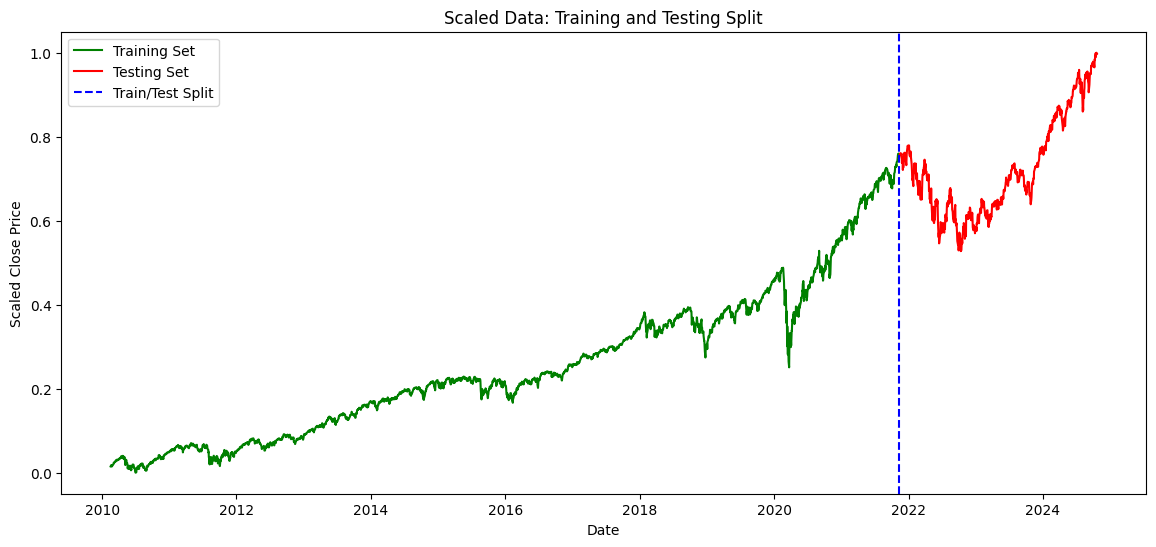

In [23]:
# Visualize the train/test split
plot_scaled_train_test_split(scaled_df, split_index)

In [24]:
# For MLP, flatten the input
X_train_mlp = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]))
X_test_mlp = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]))

print(f"Shape of X_train_mlp: {X_train_mlp.shape}")
print(f"Shape of X_test_mlp: {X_test_mlp.shape}")

Shape of X_train_mlp: (2932, 60)
Shape of X_test_mlp: (734, 60)


# Define the Models

In [25]:
def build_model_tkan(input_shape, future_steps=1):
    """
    Builds and compiles the TKAN model.

    Args:
        input_shape (tuple): Shape of the input data.
        future_steps (int): Number of future steps to predict.

    Returns:
        keras.Model: Compiled TKAN model.
    """
    model = Sequential([
        TKAN(200, sub_kan_configs=[
            {'spline_order': 4, 'grid_size': 12},
            {'spline_order': 3, 'grid_size': 10},
            {'spline_order': 5, 'grid_size': 8}
        ],
            return_sequences=False, use_bias=True),
        Dense(units=future_steps, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Build TKAN model
model_tkan = build_model_tkan(input_shape=(window_size, X_train.shape[2]), future_steps=1)

In [26]:
def build_model_mlp(input_shape, future_steps=1):
    """
    Builds and compiles the MLP model.

    Args:
        input_shape (tuple): Shape of the input data.
        future_steps (int): Number of future steps to predict.

    Returns:
        keras.Model: Compiled MLP model.
    """
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape[0],)),
        Dense(64, activation='relu'),
        Dense(future_steps, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Build MLP model
model_mlp = build_model_mlp(input_shape=(X_train_mlp.shape[1],), future_steps=1)

In [27]:
def build_model_lstm(input_shape, future_steps=1):
    """
    Builds and compiles the LSTM model.

    Args:
        input_shape (tuple): Shape of the input data.
        future_steps (int): Number of future steps to predict.

    Returns:
        keras.Model: Compiled LSTM model.
    """
    model = Sequential([
        LSTM(200, input_shape=input_shape, return_sequences=False),
        Dense(future_steps, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Build LSTM model
model_lstm = build_model_lstm(input_shape=(window_size, X_train.shape[2]), future_steps=1)

# Train the Models

In [28]:
def train_model(model, X_train, y_train, epochs=50, batch_size=32, callbacks=None):
    """
    Trains the given model on the training data.

    Args:
        model (keras.Model): The model to train.
        X_train (np.ndarray): Training features.
        y_train (np.ndarray): Training targets.
        epochs (int): Number of training epochs.
        batch_size (int): Size of training batches.
        callbacks (list): List of Keras callbacks.

    Returns:
        History object: Training history.
    """
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
        callbacks=callbacks
    )
    return history

In [29]:
# Define Early Stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [30]:
# Train TKAN Model
print("Training TKAN Model with Early Stopping...")
history_tkan = train_model(model_tkan, X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])

Training TKAN Model with Early Stopping...
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - loss: 0.0432 - val_loss: 0.0568
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0053 - val_loss: 0.0207
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.8745e-04 - val_loss: 5.5330e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.9967e-05 - val_loss: 4.9638e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.3423e-05 - val_loss: 4.9481e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 6.7338e-05 - val_loss: 4.7540e-04
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.8882e-05 - val_loss: 4.2730e-04
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 9.4945e-05 - val_loss: 4.3110e-04
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9.2479e-05 - val_loss: 4.4940e-04
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/s

In [31]:
# Train MLP Model
print("Training MLP Model with Early Stopping...")
history_mlp = train_model(model_mlp, X_train_mlp, y_train, epochs=50, batch_size=32, callbacks=[early_stop])

Training MLP Model with Early Stopping...
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0027 - val_loss: 6.2032e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8092e-05 - val_loss: 3.7448e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.5818e-05 - val_loss: 4.1376e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8156e-05 - val_loss: 3.6944e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7101e-05 - val_loss: 3.7412e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.6516e-05 - val_loss: 2.8150e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8156e-05 - val_loss: 2.8912e-04
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.2229e-05 - val_loss: 4.3364e-04
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2816e-05 - val_loss: 4.5646e-04
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5838e-05 - val_loss: 4.2272e-04
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0

In [32]:
# Train LSTM Model
print("Training LSTM Model with Early Stopping...")
history_lstm = train_model(model_lstm, X_train, y_train, epochs=50, batch_size=32, callbacks=[early_stop])

Training LSTM Model with Early Stopping...
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0052 - val_loss: 5.3170e-04
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.8582e-05 - val_loss: 4.8202e-04
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3019e-05 - val_loss: 4.3463e-04
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8605e-05 - val_loss: 4.0682e-04
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7750e-05 - val_loss: 3.7672e-04
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7294e-05 - val_loss: 3.5456e-04
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5278e-05 - val_loss: 3.3619e-04
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2731e-05 - val_loss: 3.2069e-04
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9971e-05 - val_loss: 3.0798e-04
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6960e-05 - val_loss: 2.9759e-04


# Make Predictions

In [33]:
def predict_model(model, X_test):
    """
    Uses the trained model to make predictions on the test set.

    Args:
        model (keras.Model): Trained model.
        X_test (np.ndarray): Test features.

    Returns:
        np.ndarray: Predictions.
    """
    return model.predict(X_test)

In [34]:
# Predict with TKAN Model
print("Predicting with TKAN Model...")
preds_tkan = model_tkan.predict(X_test)

Predicting with TKAN Model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step


In [35]:
# Predict with MLP Model
print("Predicting with MLP Model...")
preds_mlp = model_mlp.predict(X_test_mlp)

Predicting with MLP Model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [36]:
# Predict with LSTM Model
print("Predicting with LSTM Model...")
preds_lstm = model_lstm.predict(X_test)

Predicting with LSTM Model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


# Evaluate the Models

In [37]:
def calculate_mase(y_true, y_pred, training_series, seasonality=1):
    """
    Calculates the Mean Absolute Scaled Error (MASE).

    Args:
        y_true (np.ndarray): True values.
        y_pred (np.ndarray): Predicted values.
        training_series (np.ndarray): Training time series for scaling.
        seasonality (int): Seasonality period.

    Returns:
        float: MASE value.
    """
    mae = mean_absolute_error(y_true, y_pred)
    # Calculate in-sample MAE using the training data
    mae_insample = mean_absolute_error(training_series[:-seasonality], training_series[seasonality:])
    mase = mae / mae_insample
    return mase

In [38]:
def evaluate_model(y_test, y_pred, scaler, training_series):
    """
    Evaluates the model's performance using RMSE, MAE, and MASE.

    Args:
        y_test (np.ndarray): True target values (scaled).
        y_pred (np.ndarray): Predicted values (scaled).
        scaler (MinMaxScaler): Scaler used for inverse transformation.
        training_series (np.ndarray): Training series for MASE calculation.

    Returns:
        dict: Dictionary containing RMSE, MAE, and MASE.
    """
    # Manually inverse transform
    # 'Close_Scaled' is the first feature
    y_test_inv = y_test / scaler.scale_[0] - scaler.min_[0]
    y_pred_inv = y_pred / scaler.scale_[0] - scaler.min_[0]

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    mase = calculate_mase(
        y_true=y_test_inv.flatten(),
        y_pred=y_pred_inv.flatten(),
        training_series=training_series.flatten(),
        seasonality=1
    )

    return {'RMSE': rmse, 'MAE': mae, 'MASE': mase}

In [39]:
# Extract training series for MASE calculation
training_series = scaled_data[:len(X_train), 0].reshape(-1, 1)

In [40]:
# Evaluate TKAN model
print("Evaluating TKAN Model...")
metrics_tkan = evaluate_model(y_test, preds_tkan, scaler, training_series)
print(f"TKAN Model Metrics:\nRMSE: {metrics_tkan['RMSE']}\nMAE: {metrics_tkan['MAE']}\nMASE: {metrics_tkan['MASE']}")

Evaluating TKAN Model...
TKAN Model Metrics:
RMSE: 114.56201756966688
MAE: 95.35091557665439
MASE: 30206.88578756829


In [41]:
# Evaluate MLP model
print("Evaluating MLP Model...")
metrics_mlp = evaluate_model(y_test, preds_mlp, scaler, training_series)
print(f"MLP Model Metrics:\nRMSE: {metrics_mlp['RMSE']}\nMAE: {metrics_mlp['MAE']}\nMASE: {metrics_mlp['MASE']}")

Evaluating MLP Model...
MLP Model Metrics:
RMSE: 86.7792637306552
MAE: 69.73343375486813
MASE: 22091.343919134815


In [42]:
# Evaluate LSTM model
print("Evaluating LSTM Model...")
metrics_lstm = evaluate_model(y_test, preds_lstm, scaler, training_series)
print(f"LSTM Model Metrics:\nRMSE: {metrics_lstm['RMSE']}\nMAE: {metrics_lstm['MAE']}\nMASE: {metrics_lstm['MASE']}")

Evaluating LSTM Model...
LSTM Model Metrics:
RMSE: 132.17537218184364
MAE: 98.12643389583407
MASE: 31086.161716506424


In [43]:
def calculate_hit_ratio(y_test, y_pred):
    """
    Calculates the hit ratio (directional accuracy) of predictions.

    Args:
        y_test (np.ndarray): Actual target values.
        y_pred (np.ndarray): Predicted target values.

    Returns:
        float: Hit ratio as a percentage.
    """
    # Ensure inputs are 1D arrays
    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # Calculate the direction of actual and predicted values
    actual_direction = np.sign(y_test[1:] - y_test[:-1])
    predicted_direction = np.sign(y_pred[1:] - y_pred[:-1])

    # Calculate hits where directions match
    hits = np.sum(actual_direction == predicted_direction)
    total = len(actual_direction)

    hit_ratio = hits / total * 100
    return hit_ratio

In [44]:
# Calculate hit ratio for TKAN model
hit_ratio_tkan = calculate_hit_ratio(y_test, preds_tkan)
print(f"Hit Ratio - TKAN Model: {hit_ratio_tkan:.2f}%")

# Calculate hit ratio for MLP model
hit_ratio_mlp = calculate_hit_ratio(y_test, preds_mlp)
print(f"Hit Ratio - MLP Model: {hit_ratio_mlp:.2f}%")

# Calculate hit ratio for LSTM model
hit_ratio_lstm = calculate_hit_ratio(y_test, preds_lstm)
print(f"Hit Ratio - LSTM Model: {hit_ratio_lstm:.2f}%")

Hit Ratio - TKAN Model: 50.20%
Hit Ratio - MLP Model: 49.11%
Hit Ratio - LSTM Model: 51.57%


In [45]:
def plot_actual_vs_predicted(y_test, y_pred, scaler, model_name):
    """
    Plots actual vs. predicted values.

    Args:
        y_test (np.ndarray): True target values (scaled).
        y_pred (np.ndarray): Predicted values (scaled).
        scaler (MinMaxScaler): Scaler used for inverse transformation.
        model_name (str): Name of the model.
    """
    # Manually inverse transform
    # 'Close_Scaled' is the first feature
    y_test_inv = y_test / scaler.scale_[0] - scaler.min_[0]
    y_pred_inv = y_pred / scaler.scale_[0] - scaler.min_[0]

    plt.figure(figsize=(10,4))
    plt.plot(y_test_inv, label='Actual', color='blue')
    plt.plot(y_pred_inv, label='Predicted', color='red')
    plt.title(f'Actual vs. Predicted - {model_name}')
    plt.xlabel('Samples')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.show()

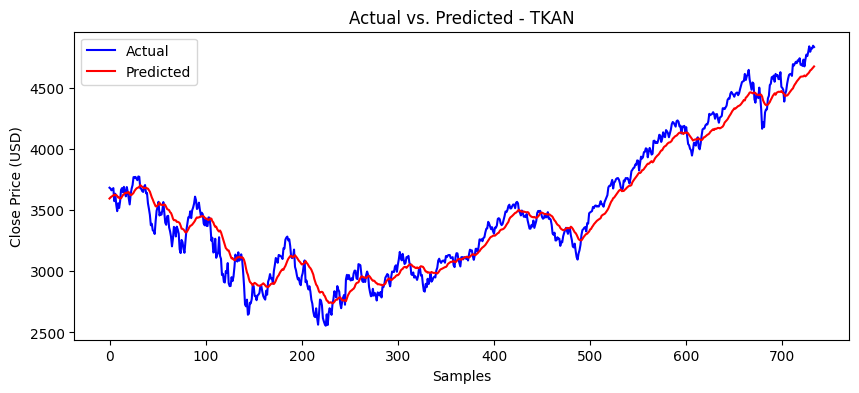

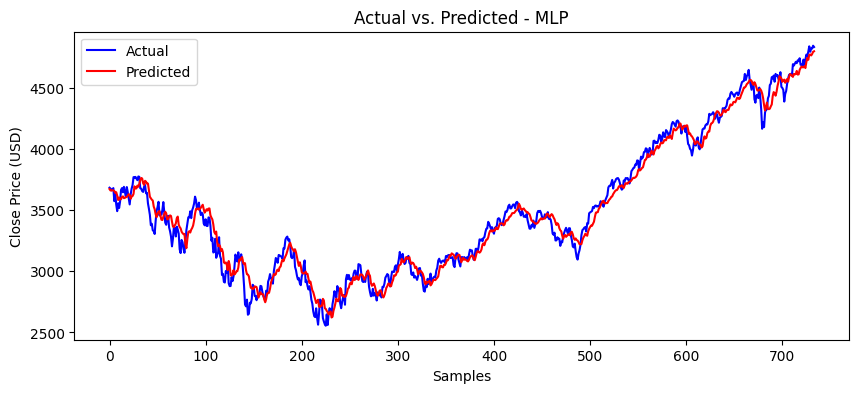

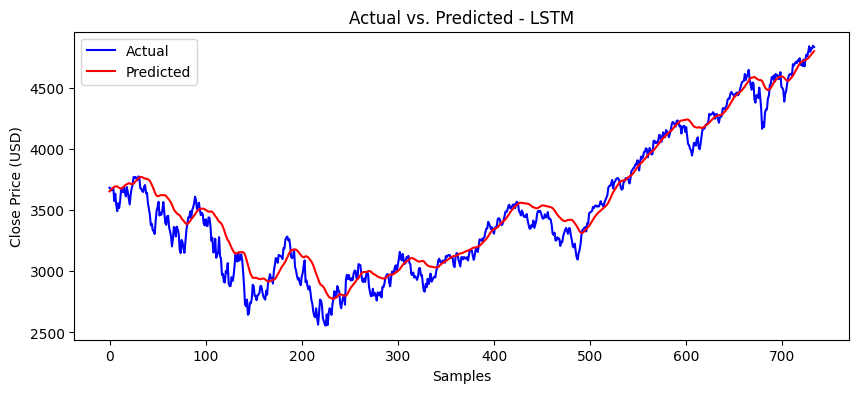

In [46]:
# Plot actual vs. predicted for TKAN model
plot_actual_vs_predicted(y_test, preds_tkan, scaler, model_name='TKAN')

# Plot actual vs. predicted for MLP model
plot_actual_vs_predicted(y_test, preds_mlp, scaler, model_name='MLP')

# Plot actual vs. predicted for LSTM model
plot_actual_vs_predicted(y_test, preds_lstm, scaler, model_name='LSTM')

In [78]:
def plot_all_models(y_test, preds_tkan, preds_mlp, preds_lstm, scaler):
    """
    Plots actual and all model predictions together.

    Args:
        y_test (np.ndarray): True target values (scaled).
        preds_tkan (np.ndarray): Predictions from TKAN model.
        preds_mlp (np.ndarray): Predictions from MLP model.
        preds_lstm (np.ndarray): Predictions from LSTM model.
        scaler (MinMaxScaler): Scaler used for inverse transformation.
    """
    # Manually inverse transform
    # 'Close_Scaled' is the first feature
    y_test_inv = y_test / scaler.scale_[0] - scaler.min_[0]

    preds_tkan_inv = preds_tkan / scaler.scale_[0] - scaler.min_[0]
    preds_mlp_inv = preds_mlp / scaler.scale_[0] - scaler.min_[0]
    preds_lstm_inv = preds_lstm / scaler.scale_[0] - scaler.min_[0]

    plt.figure(figsize=(14,7))
    plt.plot(y_test_inv, label='Actual', color='black')
    plt.plot(preds_tkan_inv, label='TKAN Predicted', alpha=0.7, linestyle='--')
    plt.plot(preds_mlp_inv, label='MLP Predicted', alpha=0.7, linestyle='--')
    plt.plot(preds_lstm_inv, label='LSTM Predicted', alpha=0.7, linestyle='--')
    plt.title('Actual vs. Predicted Close Prices by Models')
    plt.xlabel('Samples')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.show()

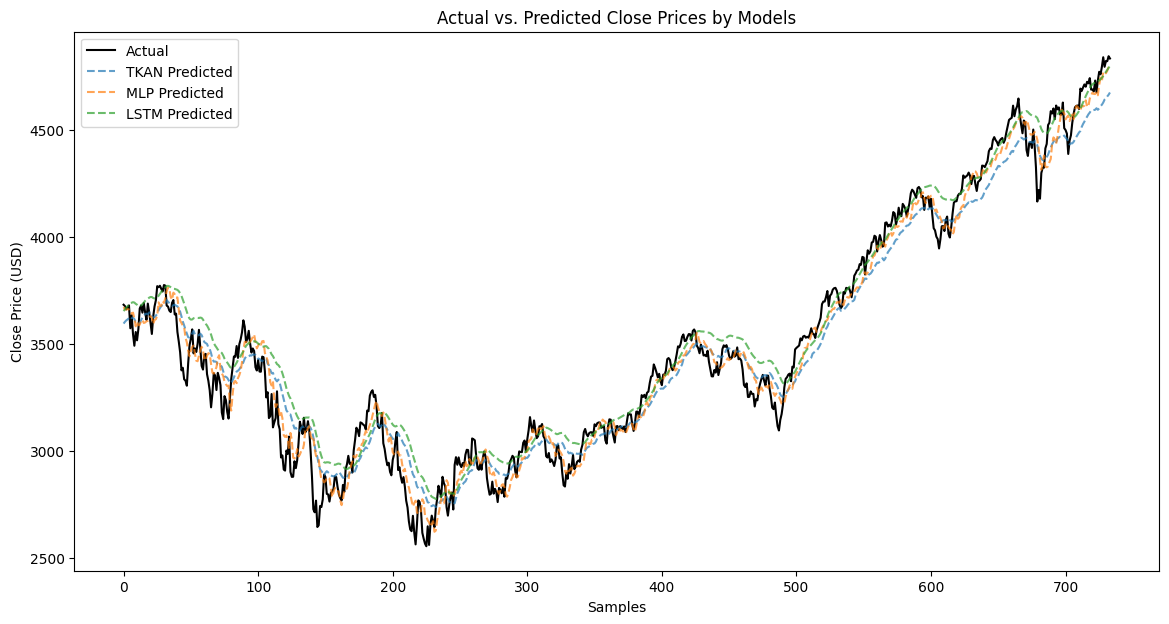

In [79]:
# Plot all the model predictions together
plot_all_models(y_test, preds_tkan, preds_mlp, preds_lstm, scaler)

In [49]:
# Create a DataFrame to store metrics including Hit Ratio
metrics_data = {
    'Model': ['TKAN', 'MLP', 'LSTM'],
    'RMSE': [metrics_tkan['RMSE'], metrics_mlp['RMSE'], metrics_lstm['RMSE']],
    'MAE': [metrics_tkan['MAE'], metrics_mlp['MAE'], metrics_lstm['MAE']],
    'MASE': [metrics_tkan['MASE'], metrics_mlp['MASE'], metrics_lstm['MASE']],
    'Hit Ratio (%)': [hit_ratio_tkan, hit_ratio_mlp, hit_ratio_lstm]
}

metrics_df = pd.DataFrame(metrics_data)
print("Evaluation Metrics:")
display(metrics_df)

Evaluation Metrics:


,Model,RMSE,MAE,MASE,Hit Ratio (%)
0,TKAN,114.562018,95.350916,30206.885788,50.204638
1,MLP,86.779264,69.733434,22091.343919,49.113233
2,LSTM,132.175372,98.126434,31086.161717,51.568895


In [50]:
def plot_metrics_comparison(metrics_df):
    """
    Plots a bar chart comparing RMSE and MAE across models.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing metrics.
    """
    metrics = ['RMSE', 'MAE']
    models = metrics_df['Model']

    x = np.arange(len(models))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width / 2, metrics_df['RMSE'], width, label='RMSE')
    ax.bar(x + width / 2, metrics_df['MAE'], width, label='MAE')

    ax.set_xlabel('Model')
    ax.set_ylabel('Metric Value')
    ax.set_title('Evaluation Metrics by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    plt.show()

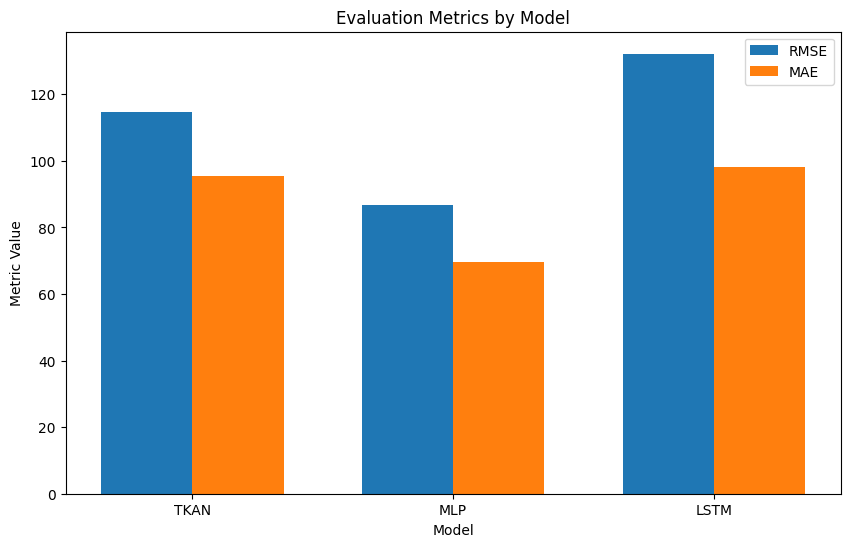

In [51]:
# Plot evaluation metrics comparison
plot_metrics_comparison(metrics_df)

# Hyperparameter Tuning

In [52]:
def objective_tkan(trial):
    """
    Objective function for hyperparameter tuning of TKAN model.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.

    Returns:
        float: Validation loss to minimize.
    """
    # Define hyperparameters to tune
    tkan_units = trial.suggest_int('tkan_units', 50, 300)

    spline_order_1 = trial.suggest_int('spline_order_1', 2, 5)
    grid_size_1 = trial.suggest_int('grid_size_1', 8, 16)

    spline_order_2 = trial.suggest_int('spline_order_2', 2, 5)
    grid_size_2 = trial.suggest_int('grid_size_2', 8, 16)

    spline_order_3 = trial.suggest_int('spline_order_3', 2, 5)
    grid_size_3 = trial.suggest_int('grid_size_3', 8, 16)

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build model with current hyperparameters
    model = Sequential([
        TKAN(tkan_units, sub_kan_configs=[
            {'spline_order': spline_order_1, 'grid_size': grid_size_1},
            {'spline_order': spline_order_2, 'grid_size': grid_size_2},
            {'spline_order': spline_order_3, 'grid_size': grid_size_3}
        ],
            return_sequences=False, use_bias=True),
        Dense(units=1, activation='linear')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Define cross-validation strategy
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define Early Stopping for each fold
        early_stop_fold = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train model
        history = model.fit(
            X_tr, y_tr,
            epochs=50,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stop_fold, KerasPruningCallback(trial, 'val_loss')],
            verbose=0
        )

        # Evaluate on validation set
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        val_losses.append(val_loss)

    # Return the average validation loss
    return np.mean(val_losses)

In [53]:
# Create an Optuna study for TKAN model with pruning
study_tkan = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())

print("Starting hyperparameter tuning for TKAN Model...")
study_tkan.optimize(objective_tkan, n_trials=50, timeout=None)

print("Hyperparameter tuning for TKAN Model completed.")
print("Best trial:")
trial = study_tkan.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-10-22 03:38:30,099] A new study created in memory with name: no-name-5d552fad-4f02-417f-bacd-82a97c5eb198


Starting hyperparameter tuning for TKAN Model...


[I 2024-10-22 03:40:18,945] Trial 0 finished with value: 0.00014536880674616745 and parameters: {'tkan_units': 294, 'spline_order_1': 4, 'grid_size_1': 10, 'spline_order_2': 5, 'grid_size_2': 9, 'spline_order_3': 4, 'grid_size_3': 8, 'learning_rate': 0.0005484918083048688}. Best is trial 0 with value: 0.00014536880674616745.
[I 2024-10-22 03:41:44,825] Trial 1 finished with value: 0.0015274156127513077 and parameters: {'tkan_units': 246, 'spline_order_1': 4, 'grid_size_1': 15, 'spline_order_2': 3, 'grid_size_2': 8, 'spline_order_3': 5, 'grid_size_3': 10, 'learning_rate': 0.0006170574326508769}. Best is trial 0 with value: 0.00014536880674616745.
[I 2024-10-22 03:42:57,942] Trial 2 finished with value: 0.0013690199933383458 and parameters: {'tkan_units': 187, 'spline_order_1': 2, 'grid_size_1': 14, 'spline_order_2': 5, 'grid_size_2': 14, 'spline_order_3': 2, 'grid_size_3': 13, 'learning_rate': 0.00557276387356693}. Best is trial 0 with value: 0.00014536880674616745.
[I 2024-10-22 03:44:

Hyperparameter tuning for TKAN Model completed.
Best trial:
  Value: 0.00014536880674616745
  Params: 
    tkan_units: 294
    spline_order_1: 4
    grid_size_1: 10
    spline_order_2: 5
    grid_size_2: 9
    spline_order_3: 4
    grid_size_3: 8
    learning_rate: 0.0005484918083048688


In [54]:
def objective_mlp(trial):
    """
    Objective function for hyperparameter tuning of MLP model.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.

    Returns:
        float: Validation loss to minimize.
    """
    # Define hyperparameters to tune
    n_hidden1 = trial.suggest_int('n_hidden1', 64, 256)
    n_hidden2 = trial.suggest_int('n_hidden2', 32, 128)

    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build model with current hyperparameters
    model = Sequential([
        Dense(n_hidden1, activation='relu', input_shape=(X_train_mlp.shape[1],)),
        Dense(n_hidden2, activation='relu'),
        Dense(1, activation='linear')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Define cross-validation strategy
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X_train_mlp)):
        X_tr, X_val = X_train_mlp[train_index], X_train_mlp[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define Early Stopping for each fold
        early_stop_fold = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train model
        history = model.fit(
            X_tr, y_tr,
            epochs=50,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stop_fold, KerasPruningCallback(trial, 'val_loss')],
            verbose=0
        )

        # Evaluate on validation set
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        val_losses.append(val_loss)

    # Return the average validation loss
    return np.mean(val_losses)

In [55]:
# Create an Optuna study for MLP model with pruning
study_mlp = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())

print("Starting hyperparameter tuning for MLP Model...")
study_mlp.optimize(objective_mlp, n_trials=50, timeout=None)

print("Hyperparameter tuning for MLP Model completed.")
print("Best trial:")
trial = study_mlp.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-10-22 04:13:47,210] A new study created in memory with name: no-name-7fda3776-a8c4-4456-a577-2f59c253aa62


Starting hyperparameter tuning for MLP Model...


[I 2024-10-22 04:13:58,732] Trial 0 finished with value: 7.69737101412223e-05 and parameters: {'n_hidden1': 108, 'n_hidden2': 98, 'learning_rate': 0.0018777111586156588}. Best is trial 0 with value: 7.69737101412223e-05.
[I 2024-10-22 04:14:08,666] Trial 1 finished with value: 7.256496367820849e-05 and parameters: {'n_hidden1': 123, 'n_hidden2': 87, 'learning_rate': 0.0003985833438451162}. Best is trial 1 with value: 7.256496367820849e-05.
[I 2024-10-22 04:14:22,226] Trial 2 finished with value: 5.9391717513790354e-05 and parameters: {'n_hidden1': 218, 'n_hidden2': 104, 'learning_rate': 0.0003095566342560633}. Best is trial 2 with value: 5.9391717513790354e-05.
[I 2024-10-22 04:14:34,252] Trial 3 finished with value: 6.816145044770867e-05 and parameters: {'n_hidden1': 245, 'n_hidden2': 117, 'learning_rate': 0.0009454294108282596}. Best is trial 2 with value: 5.9391717513790354e-05.
[I 2024-10-22 04:14:46,820] Trial 4 finished with value: 8.23116230700786e-05 and parameters: {'n_hidden1

Hyperparameter tuning for MLP Model completed.
Best trial:
  Value: 5.76929748300851e-05
  Params: 
    n_hidden1: 149
    n_hidden2: 92
    learning_rate: 0.0013225554007030953


In [56]:
def objective_lstm(trial):
    """
    Objective function for hyperparameter tuning of LSTM model.

    Args:
        trial (optuna.trial.Trial): Optuna trial object.

    Returns:
        float: Validation loss to minimize.
    """
    # Define hyperparameters to tune
    lstm_units = trial.suggest_int('lstm_units', 50, 300)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build model with current hyperparameters
    model = Sequential([
        LSTM(lstm_units, input_shape=(window_size, X_train.shape[2]), return_sequences=False),
        Dense(1, activation='linear')
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Define cross-validation strategy
    tscv = TimeSeriesSplit(n_splits=3)
    val_losses = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X_train)):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define Early Stopping for each fold
        early_stop_fold = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train model
        history = model.fit(
            X_tr, y_tr,
            epochs=50,
            batch_size=32,
            validation_data=(X_val, y_val),
            callbacks=[early_stop_fold, KerasPruningCallback(trial, 'val_loss')],
            verbose=0
        )

        # Evaluate on validation set
        val_loss = model.evaluate(X_val, y_val, verbose=0)
        val_losses.append(val_loss)

    # Return the average validation loss
    return np.mean(val_losses)

In [57]:
# Create an Optuna study for LSTM model with pruning
study_lstm = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner())

print("Starting hyperparameter tuning for LSTM Model...")
study_lstm.optimize(objective_lstm, n_trials=50, timeout=None)

print("Hyperparameter tuning for LSTM Model completed.")
print("Best trial:")
trial = study_lstm.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2024-10-22 04:17:32,653] A new study created in memory with name: no-name-d57018c9-9591-42ee-a117-8ef6a1ba1f86


Starting hyperparameter tuning for LSTM Model...


[I 2024-10-22 04:17:58,385] Trial 0 finished with value: 3.9567489996746495e-05 and parameters: {'lstm_units': 171, 'learning_rate': 0.0007932885911789039}. Best is trial 0 with value: 3.9567489996746495e-05.
[I 2024-10-22 04:18:09,836] Trial 1 finished with value: 7.3935426674628e-05 and parameters: {'lstm_units': 293, 'learning_rate': 0.006864578650097444}. Best is trial 0 with value: 3.9567489996746495e-05.
[I 2024-10-22 04:18:25,168] Trial 2 finished with value: 7.263507723109797e-05 and parameters: {'lstm_units': 191, 'learning_rate': 0.00025487203376391013}. Best is trial 0 with value: 3.9567489996746495e-05.
[I 2024-10-22 04:18:39,941] Trial 3 finished with value: 3.9537943545534894e-05 and parameters: {'lstm_units': 203, 'learning_rate': 0.003329644738432764}. Best is trial 3 with value: 3.9537943545534894e-05.
[I 2024-10-22 04:18:54,982] Trial 4 finished with value: 6.393371222657152e-05 and parameters: {'lstm_units': 295, 'learning_rate': 0.006790988854088423}. Best is trial 

Hyperparameter tuning for LSTM Model completed.
Best trial:
  Value: 3.621050048726223e-05
  Params: 
    lstm_units: 190
    learning_rate: 0.0027497686700321752


# Retrain the Models

In [58]:
# Extract best hyperparameters for TKAN model
best_params_tkan = study_tkan.best_trial.params

# Build TKAN model with best hyperparameters
model_tkan_best = Sequential([
    TKAN(best_params_tkan['tkan_units'], sub_kan_configs=[
        {'spline_order': best_params_tkan['spline_order_1'], 'grid_size': best_params_tkan['grid_size_1']},
        {'spline_order': best_params_tkan['spline_order_2'], 'grid_size': best_params_tkan['grid_size_2']},
        {'spline_order': best_params_tkan['spline_order_3'], 'grid_size': best_params_tkan['grid_size_3']}
    ],
        return_sequences=False, use_bias=True),
    Dense(units=1, activation='linear')
])
optimizer_tkan_best = Adam(learning_rate=best_params_tkan['learning_rate'])
model_tkan_best.compile(optimizer=optimizer_tkan_best, loss='mse')

# Define Early Stopping for retraining
early_stop_best_tkan = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train TKAN model with best hyperparameters
print("Retraining TKAN Model with Best Hyperparameters and Early Stopping...")
history_tkan_best = train_model(model_tkan_best, X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop_best_tkan])

Retraining TKAN Model with Best Hyperparameters and Early Stopping...
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 30s 181ms/step - loss: 0.0263 - val_loss: 0.0753
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0056 - val_loss: 0.0190
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 2.6279e-04 - val_loss: 4.8683e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.0778e-05 - val_loss: 4.8425e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 9.5469e-05 - val_loss: 4.5872e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 8.7702e-05 - val_loss: 6.6603e-04
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.3423e-04 - val_loss: 5.3681e-04
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.4521e-04 - val_loss: 4.6060e-04
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.7504e-04 - val_loss: 4.2302e-04
Epoch 11/10

In [59]:
# Extract best hyperparameters for MLP model
best_params_mlp = study_mlp.best_trial.params

# Build MLP model with best hyperparameters
model_mlp_best = Sequential([
    Dense(best_params_mlp['n_hidden1'], activation='relu', input_shape=(X_train_mlp.shape[1],)),
    Dense(best_params_mlp['n_hidden2'], activation='relu'),
    Dense(1, activation='linear')
])
optimizer_mlp_best = Adam(learning_rate=best_params_mlp['learning_rate'])
model_mlp_best.compile(optimizer=optimizer_mlp_best, loss='mse')

# Define Early Stopping for retraining
early_stop_best_mlp = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train MLP model with best hyperparameters
print("Retraining MLP Model with Best Hyperparameters and Early Stopping...")
history_mlp_best = train_model(model_mlp_best, X_train_mlp, y_train, epochs=100, batch_size=32, callbacks=[early_stop_best_mlp])

Retraining MLP Model with Best Hyperparameters and Early Stopping...
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0111 - val_loss: 6.9412e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6595e-05 - val_loss: 3.3976e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7058e-05 - val_loss: 3.6939e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2798e-05 - val_loss: 2.8086e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.7604e-05 - val_loss: 2.5817e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4848e-05 - val_loss: 2.3853e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1562e-05 - val_loss: 2.2658e-04
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3075e-05 - val_loss: 2.4269e-04
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0443e-05 - val_loss: 2.2321e-04
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9641e-05 - val_loss: 2.2410e-04
Epo

In [60]:
# Extract best hyperparameters for LSTM model
best_params_lstm = study_lstm.best_trial.params

# Build LSTM model with best hyperparameters
model_lstm_best = Sequential([
    LSTM(best_params_lstm['lstm_units'], input_shape=(window_size, X_train.shape[2]), return_sequences=False),
    Dense(1, activation='linear')
])
optimizer_lstm_best = Adam(learning_rate=best_params_lstm['learning_rate'])
model_lstm_best.compile(optimizer=optimizer_lstm_best, loss='mse')

# Define Early Stopping for retraining
early_stop_best_lstm = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train LSTM model with best hyperparameters
print("Retraining LSTM Model with Best Hyperparameters and Early Stopping...")
history_lstm_best = train_model(model_lstm_best, X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop_best_lstm])

Retraining LSTM Model with Best Hyperparameters and Early Stopping...
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0021 - val_loss: 3.6639e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9810e-05 - val_loss: 3.3596e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8257e-05 - val_loss: 2.6798e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6634e-05 - val_loss: 2.4698e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3303e-05 - val_loss: 2.1879e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3903e-05 - val_loss: 2.0205e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2197e-05 - val_loss: 1.8818e-04
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0386e-05 - val_loss: 1.7675e-04
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8686e-05 - val_loss: 1.6716e-04
Epoch 10/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7289e-05 - val_loss: 1.5911e-04
Epo

In [61]:
# Save models
model_tkan_best.save('model_tkan_best.keras')
model_mlp_best.save('model_mlp_best.keras')
model_lstm_best.save('model_lstm_best.keras')

In [62]:
# Load models
loaded_tkan = load_model('model_tkan_best.keras', custom_objects={'TKAN': TKAN})
loaded_mlp = load_model('model_mlp_best.keras')
loaded_lstm = load_model('model_lstm_best.keras')

# Make New Predictions

In [63]:
# Predict with retrained TKAN model
print("Predicting with Retrained TKAN Model...")
preds_tkan_best = model_tkan_best.predict(X_test)

Predicting with Retrained TKAN Model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step


In [64]:
# Predict with retrained MLP model
print("Predicting with Retrained MLP Model...")
preds_mlp_best = model_mlp_best.predict(X_test_mlp)

Predicting with Retrained MLP Model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [65]:
# Predict with retrained LSTM model
print("Predicting with Retrained LSTM Model...")
preds_lstm_best = model_lstm_best.predict(X_test)

Predicting with Retrained LSTM Model...
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


# Evaluate Tuned Models

In [66]:
# Evaluate retrained TKAN model
print("Evaluating Retrained TKAN Model...")
metrics_tkan_best = evaluate_model(y_test, preds_tkan_best, scaler, training_series)
print(f"Retrained TKAN Model Metrics:\nRMSE: {metrics_tkan_best['RMSE']}\nMAE: {metrics_tkan_best['MAE']}\nMASE: {metrics_tkan_best['MASE']}")

Evaluating Retrained TKAN Model...
Retrained TKAN Model Metrics:
RMSE: 81.39051115312228
MAE: 65.1882169397662
MASE: 20651.43278264297


In [67]:
# Evaluate retrained MLP model
print("Evaluating Retrained MLP Model...")
metrics_mlp_best = evaluate_model(y_test, preds_mlp_best, scaler, training_series)
print(f"Retrained MLP Model Metrics:\nRMSE: {metrics_mlp_best['RMSE']}\nMAE: {metrics_mlp_best['MAE']}\nMASE: {metrics_mlp_best['MASE']}")

Evaluating Retrained MLP Model...
Retrained MLP Model Metrics:
RMSE: 69.36213361212936
MAE: 52.061345667850105
MASE: 16492.87909848763


In [68]:
# Evaluate retrained LSTM model
print("Evaluating Retrained LSTM Model...")
metrics_lstm_best = evaluate_model(y_test, preds_lstm_best, scaler, training_series)
print(f"Retrained LSTM Model Metrics:\nRMSE: {metrics_lstm_best['RMSE']}\nMAE: {metrics_lstm_best['MAE']}\nMASE: {metrics_lstm_best['MASE']}")

Evaluating Retrained LSTM Model...
Retrained LSTM Model Metrics:
RMSE: 48.82827514093519
MAE: 37.629685302655325
MASE: 11920.972119514174


In [69]:
# Create a DataFrame to store final metrics including Hit Ratio
metrics_final_data = {
    'Model': ['TKAN', 'MLP', 'LSTM'],
    'RMSE': [metrics_tkan_best['RMSE'], metrics_mlp_best['RMSE'], metrics_lstm_best['RMSE']],
    'MAE': [metrics_tkan_best['MAE'], metrics_mlp_best['MAE'], metrics_lstm_best['MAE']],
    'MASE': [metrics_tkan_best['MASE'], metrics_mlp_best['MASE'], metrics_lstm_best['MASE']],
    'Hit Ratio (%)': [
        calculate_hit_ratio(y_test, preds_tkan_best),
        calculate_hit_ratio(y_test, preds_mlp_best),
        calculate_hit_ratio(y_test, preds_lstm_best)
    ]
}

metrics_final_df = pd.DataFrame(metrics_final_data)
print("Final Evaluation Metrics After Hyperparameter Tuning:")
display(metrics_final_df)

Final Evaluation Metrics After Hyperparameter Tuning:


,Model,RMSE,MAE,MASE,Hit Ratio (%)
0,TKAN,81.390511,65.188217,20651.432783,50.204638
1,MLP,69.362134,52.061346,16492.879098,53.069577
2,LSTM,48.828275,37.629685,11920.972120,48.567531


In [70]:
def plot_rmse_mae_comparison(metrics_df):
    """
    Plots a grouped bar chart comparing RMSE and MAE across models.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing 'Model', 'RMSE', and 'MAE' columns.
    """
    metrics = ['RMSE', 'MAE']
    models = metrics_df['Model']

    x = np.arange(len(models))  # label locations
    width = 0.35  # width of the bars

    fig, ax = plt.subplots(figsize=(12,7))
    rects1 = ax.bar(x - width/2, metrics_df['RMSE'], width, label='RMSE', color='skyblue')
    rects2 = ax.bar(x + width/2, metrics_df['MAE'], width, label='MAE', color='salmon')

    ax.set_xlabel('Model')
    ax.set_ylabel('Error Metrics')
    ax.set_title('RMSE and MAE Comparison Across Models')
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()

    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()
    plt.show()

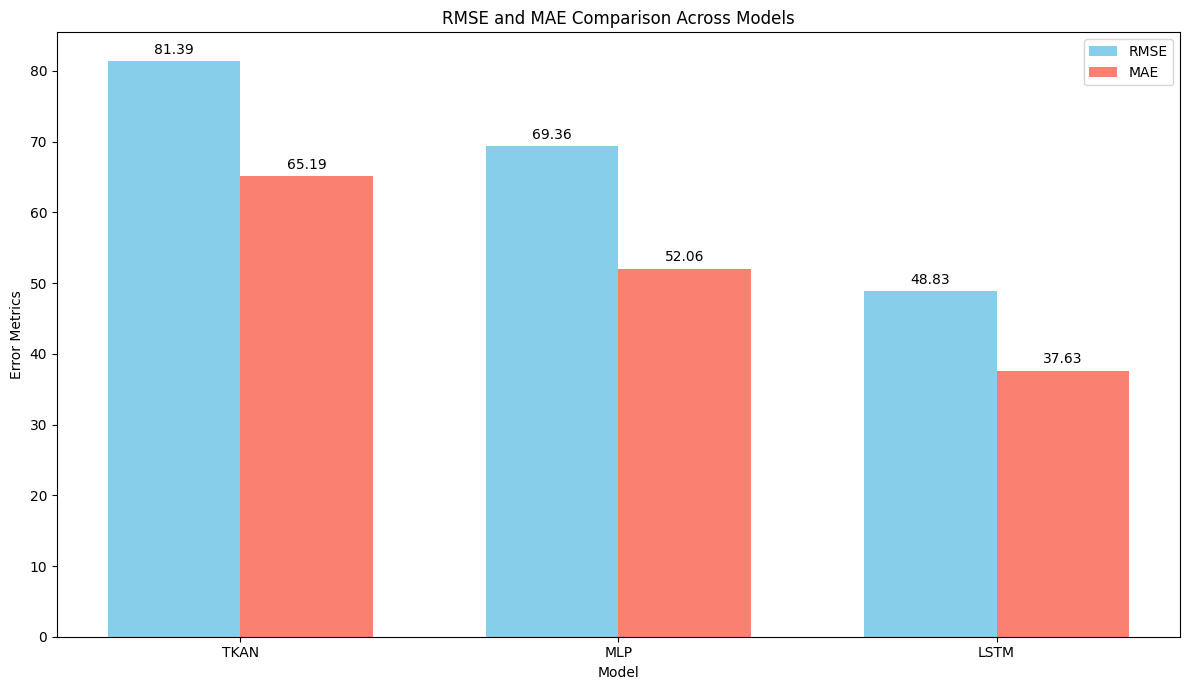

In [71]:
# Plot RMSE and MAE comparison
plot_rmse_mae_comparison(metrics_final_df)

In [72]:
def plot_mase_comparison(metrics_df):
    """
    Plots a bar chart comparing MASE across models.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing 'Model' and 'MASE' columns.
    """
    models = metrics_df['Model']
    mase = metrics_df['MASE']

    x = np.arange(len(models))  # label locations
    width = 0.6  # width of the bars

    fig, ax = plt.subplots(figsize=(12,7))
    bars = ax.bar(x, mase, width, color='lightgreen')

    ax.set_xlabel('Model')
    ax.set_ylabel('MASE')
    ax.set_title('MASE Comparison Across Models')
    ax.set_xticks(x)
    ax.set_xticklabels(models)

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

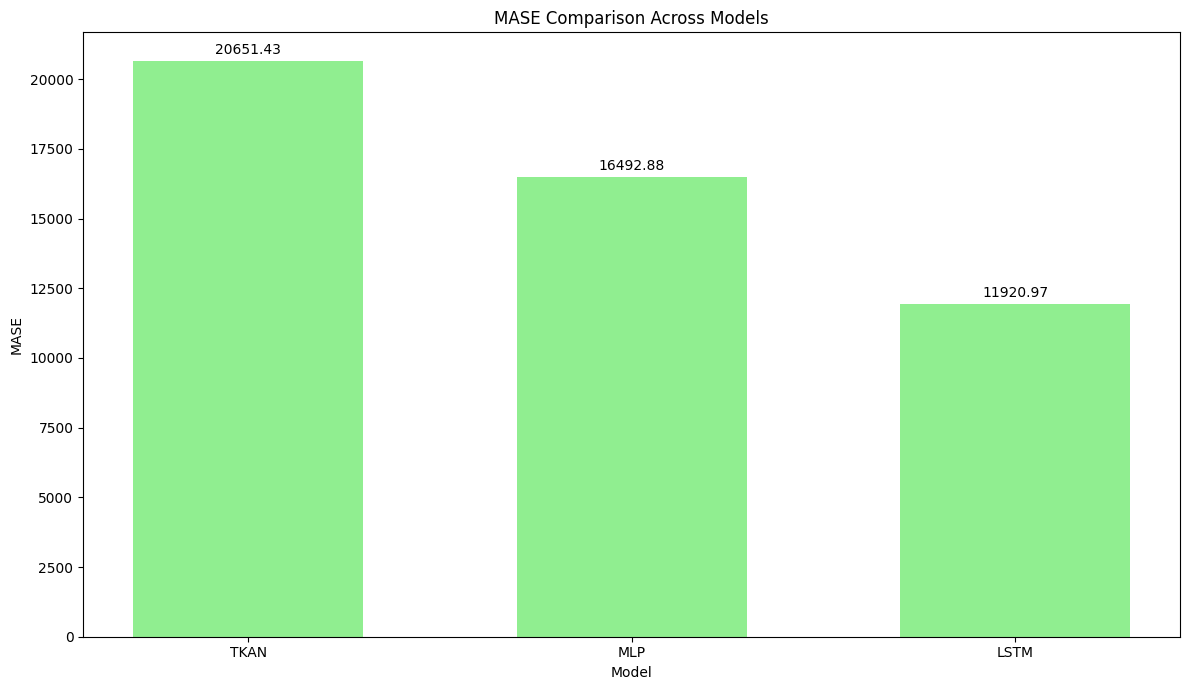

In [73]:
# Plot MASE comparison
plot_mase_comparison(metrics_final_df)

In [74]:
def plot_hit_ratio_comparison(metrics_df):
    """
    Plots a bar chart comparing Hit Ratio across models.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing 'Model' and 'Hit Ratio (%)' columns.
    """
    models = metrics_df['Model']
    hit_ratio = metrics_df['Hit Ratio (%)']

    x = np.arange(len(models))  # label locations
    width = 0.6  # width of the bars

    fig, ax = plt.subplots(figsize=(12,7))
    bars = ax.bar(x, hit_ratio, width, color='gold')

    ax.set_xlabel('Model')
    ax.set_ylabel('Hit Ratio (%)')
    ax.set_title('Hit Ratio Comparison Across Models')
    ax.set_xticks(x)
    ax.set_xticklabels(models)

    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    fig.tight_layout()
    plt.show()

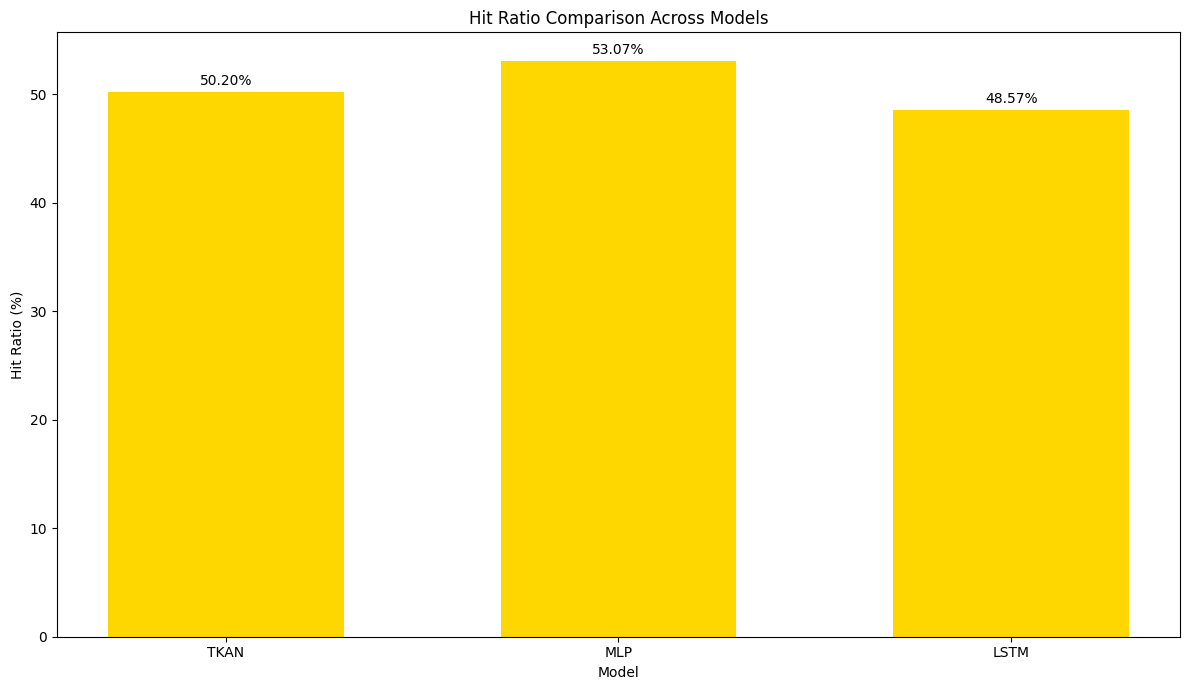

In [75]:
# Plot hit ratio comparison
plot_hit_ratio_comparison(metrics_final_df)

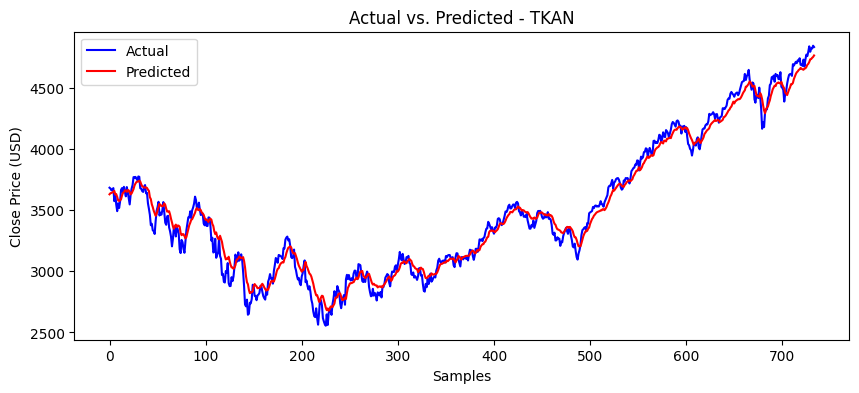

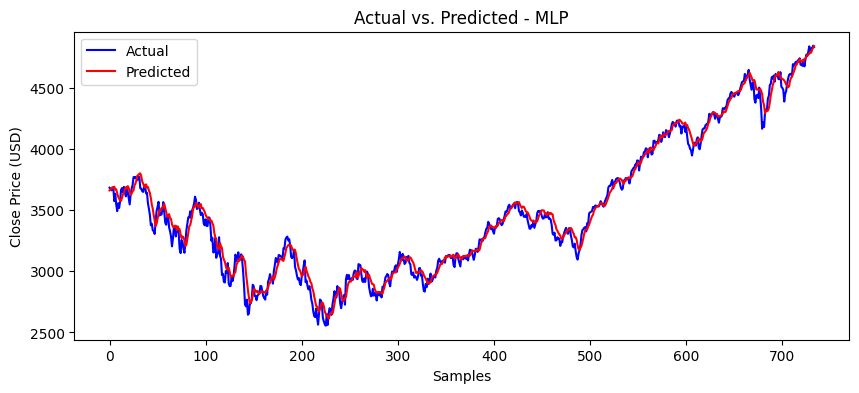

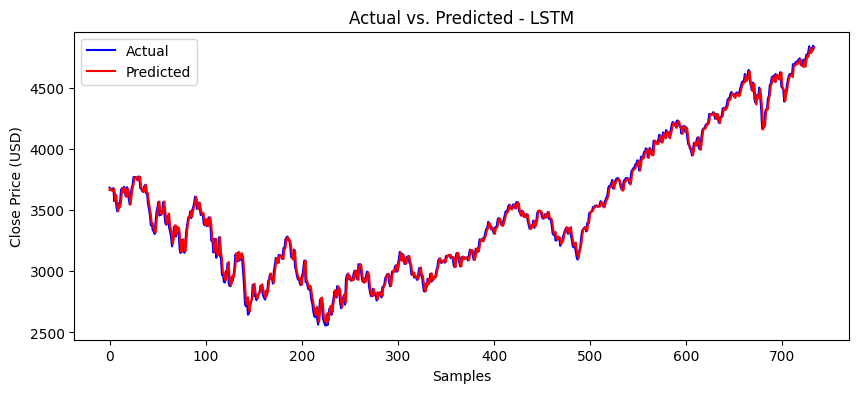

In [77]:
# Plot actual vs. predicted for TKAN model
plot_actual_vs_predicted(y_test, preds_tkan_best, scaler, model_name='TKAN')

# Plot actual vs. predicted for MLP model
plot_actual_vs_predicted(y_test, preds_mlp_best, scaler, model_name='MLP')

# Plot actual vs. predicted for LSTM model
plot_actual_vs_predicted(y_test, preds_lstm_best, scaler, model_name='LSTM')

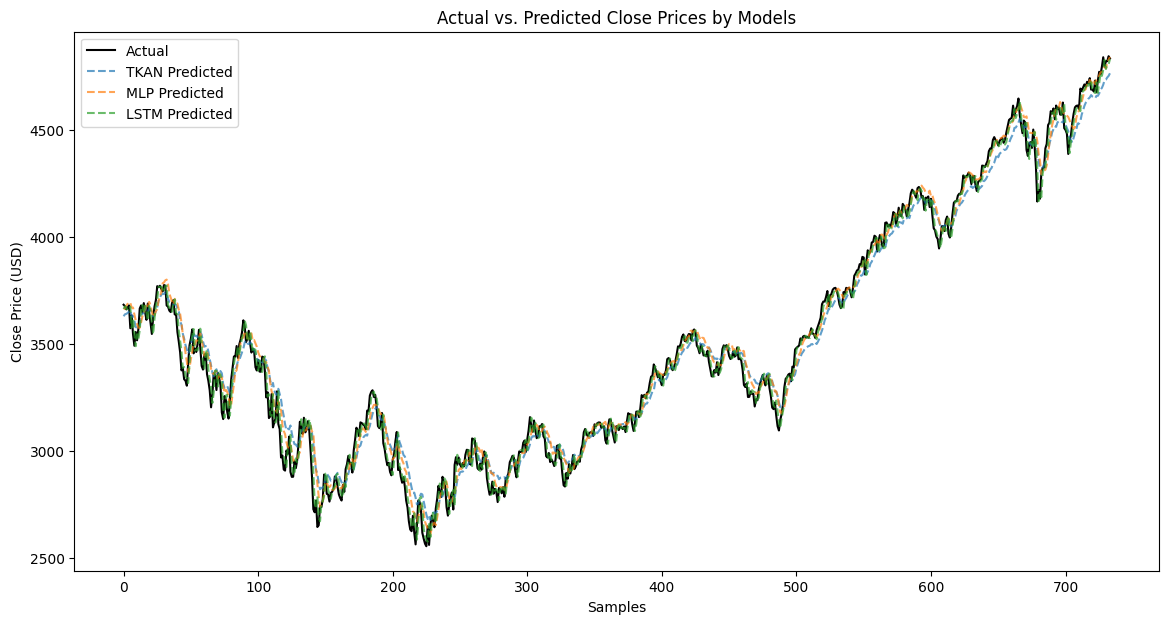

In [80]:
# Plot all the model predictions together
plot_all_models(y_test, preds_tkan_best, preds_mlp_best, preds_lstm_best, scaler)